In [ ]:
import os
import pickle
import csv
import numpy as np

# Path to the folder containing pickle files roberta-base distilbert-base-uncased
# pickle_folder = "fewshot_deberta-v3-base_32all"
# output_csv = "summary/fewshot_deberta_new_32all.csv"
pickle_folder = "fewshot_distilbert-base-uncased_32all"
output_csv = "summary/fewshot_distil_new_32all.csv"

llms = ['gpt35', 'Mixtral','Moonshot','Llama3', 'gpt-4omini']
method_map = {'baseline':'ProtNet', 'rn':'RelationNet', 'generate':'Calibration'}
# Initialize the CSV header
csv_header = ['cat','order', 'kshot', 'model', 'method', 'result','min_f1','max_f1']
tmp = []
# Open the CSV file for writing
with open(output_csv, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_header)  # Write the header
    files = os.listdir(pickle_folder)
    files.sort()
    # Loop through each pickle file in the folder
    for pickle_file in files:
        if pickle_file.endswith(".pickle"):
            # Extract the category name from the file name
            category = pickle_file.replace(".pickle", "")
            category = category.replace("1", "")
            # Load the pickle file
            with open(os.path.join(pickle_folder, pickle_file), "rb") as file:
                results = pickle.load(file)  # Assuming it's a list of dicts as in your format

            # Process each result in the pickle file
            for result in results:
                lwf_reg = result.get("kshot", "N/A")
                lr_factor = result.get("model", "N/A")
                cache_size = method_map[result.get("method", "N/A")]
                name = result.get('order', "Null")[1][0]
                if 'gpt' in name:
                    name = name.replace('gpt', 'GPT')
                # Assuming there is one DetectOutput in the 'result' field
                for out in result["result"]:
                    if result["result"]:
                        f1 = []
                        for x in result["result"]:
                            if type(x) == list:
                                f1.append(x[0].test.f1)
                            else:
                                f1.append(x.test.f1)
                mean = np.mean(f1)
                std_dev = np.std(f1)
                # 选择一个标准差的倍数，比如3
                min_f1 = min(f1)
                max_f1 = max(f1)
                threshold = 0.5
                cleaned_data = [x for x in f1 if mean - threshold * std_dev <= x]
                f1 = np.mean(cleaned_data)
                writer.writerow([category,name, lwf_reg, lr_factor, cache_size, f1,min_f1,max_f1])


print(f"Results written to {output_csv}")


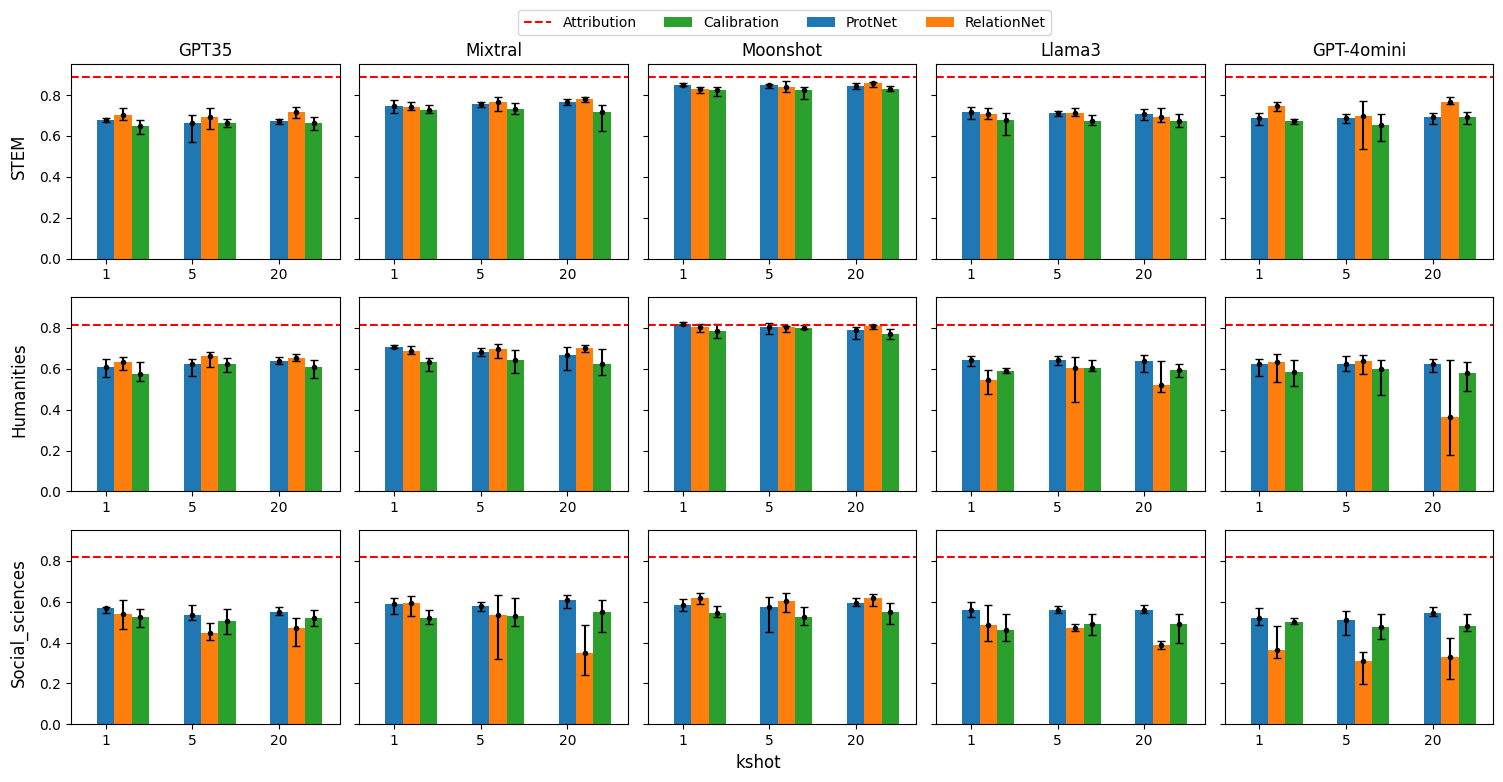

In [26]:
from cProfile import label
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from CSV
data = pd.read_csv('summary/fewshot_deberta_new.csv')

# Define the categories, orders, methods, and kshot values
categories = ['STEM', 'Humanities', 'Social_sciences']
orders = ['GPT35', 'Mixtral', 'Moonshot', 'Llama3', 'GPT-4omini']
methods = ['ProtNet', 'RelationNet', 'Calibration']
kshot_values = [1, 5, 20]

# Upper bounds for each category
upper_bounds = {
    'STEM': 0.8881,
    'Humanities': 0.8151,
    'Social_sciences': 0.8177
}

# Create subplots (3 rows x 5 columns)
fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharey=True)  # Reduced height

# Loop through each category (row)
for i, cat in enumerate(categories):
    # Loop through each order (column)
    for j, order in enumerate(orders):
        ax = axes[i, j]
        
        # Filter data for the current category and order
        cat_order_data = data[(data['cat'] == cat) & (data['order'] == order)]
        
        if cat_order_data.empty:
            ax.axis('off')  # Turn off the axis if no data is available for this order
            continue
        
        # Plot bars for each method with different kshot values
        for k, method in enumerate(methods):
            # Filter data for the current method
            method_data = cat_order_data[cat_order_data['method'] == method]
            
            # Extract results for the given kshot values
            results = [method_data[method_data['kshot'] == kshot]['result'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
            
            # Extract min_f1 and max_f1 values
            min_f1 = [method_data[method_data['kshot'] == kshot]['min_f1'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
            max_f1 = [method_data[method_data['kshot'] == kshot]['max_f1'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
            
            # Assign evenly spaced x-positions for each method
            x_positions = [i + k * 0.2 for i in range(len(kshot_values))]
            
            # Plot the bars
            bars = ax.bar(x_positions, results, width=0.2, label=method)

            # Add min_f1 and max_f1 as error bars (not part of the legend)
            for idx, bar in enumerate(bars):
                ax.errorbar(bar.get_x() + bar.get_width() / 2, results[idx],
                            yerr=[[results[idx] - min_f1[idx]], [max_f1[idx] - results[idx]]],
                            fmt='.', color='black', capsize=3)

        # Add dashed line for upper bound
        ax.axhline(upper_bounds[cat], color='red', linestyle='--', label='Attribution')

        # Customize the subplot
        ax.set_xticks(range(len(kshot_values)))  # Set custom tick positions
        ax.set_xticklabels(kshot_values)
        ax.set_xlim([-0.4, len(kshot_values) - 0.3])  # Adjust x-axis limits for better spacing
        ax.set_ylim([0, 0.95])  # Adjust x-axis limits for better spacing

        # Mark category name on the left side
        if j == 0:
            ax.text(-1, 0.5, cat, ha='center', va='center', rotation='vertical', fontsize=12)

    # Add column titles for orders
        axes[0, j].set_title(orders[j], fontsize=12)

# Set shared x-axis and y-axis labels
fig.text(0.5, 0, 'kshot', ha='center', va='center', fontsize=12)
methods.insert(0, 'Attribution')

# Move the legend above the plot
# We exclude the dashed line ('Attribution') from the legend using the `handlelength` parameter
# fig.legend(handles=bars, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels,bbox_to_anchor=(0.7, 0.95), ncol=4)
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjusted to fit the legend

# Show the plot
plt.show()


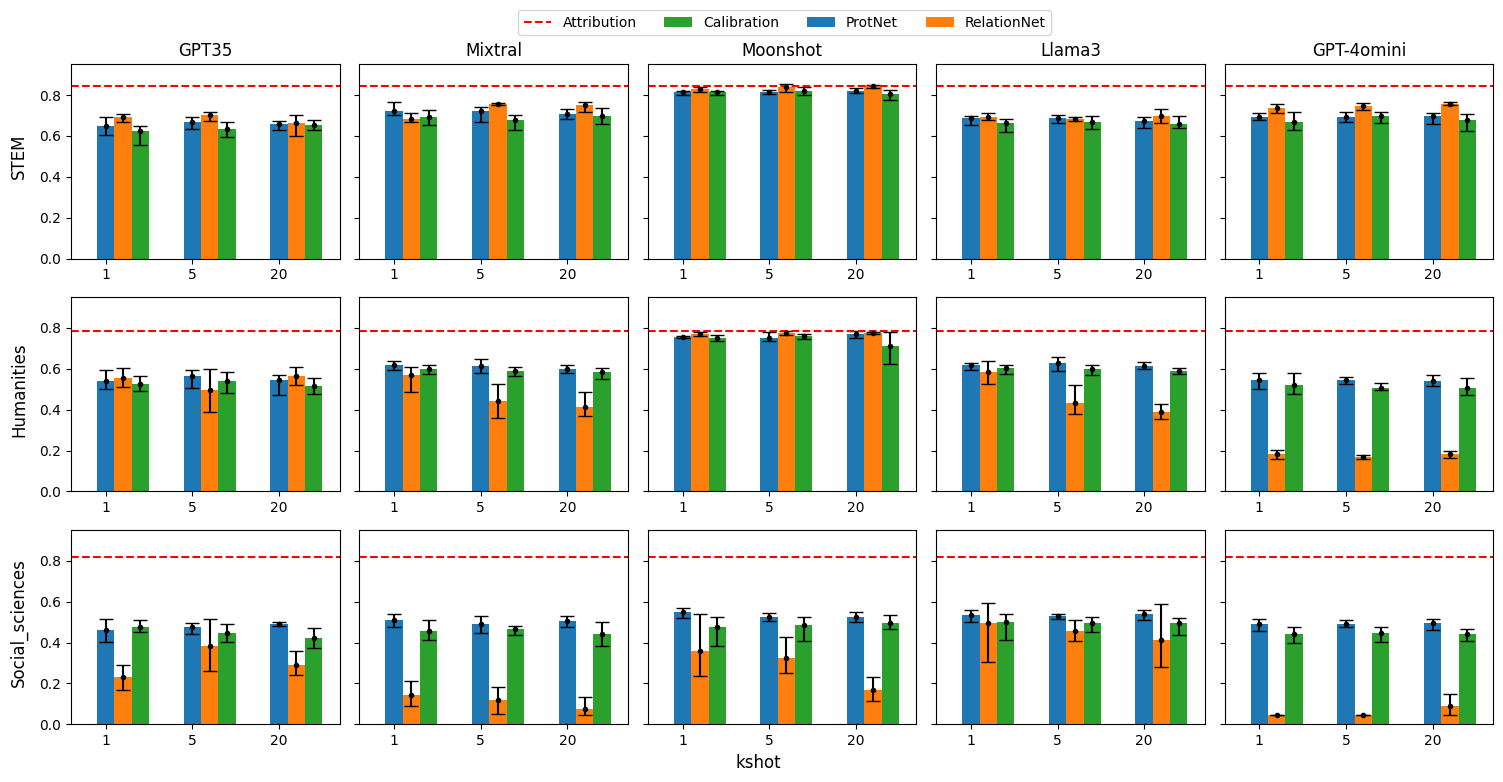

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from CSV
data = pd.read_csv('summary/fewshot_distil_new.csv')

# Define the categories, orders, methods, and kshot values
categories = ['STEM', 'Humanities', 'Social_sciences']
orders = ['GPT35', 'Mixtral', 'Moonshot', 'Llama3', 'GPT-4omini']
methods = ['ProtNet', 'RelationNet', 'Calibration']
kshot_values = [1, 5, 20]

# Upper bounds for each category
upper_bounds = {
    'STEM': 0.8444,
    'Humanities': 0.7835,
    'Social_sciences': 0.8174
}

# Create subplots (3 rows x 5 columns)
fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharey=True)  # Reduced height

# Loop through each category (row)
for i, cat in enumerate(categories):
    # Loop through each order (column)
    for j, order in enumerate(orders):
        ax = axes[i, j]
        
        # Filter data for the current category and order
        cat_order_data = data[(data['cat'] == cat) & (data['order'] == order)]
        
        if cat_order_data.empty:
            ax.axis('off')  # Turn off the axis if no data is available for this order
            continue
        
        # Plot bars for each method with different kshot values
        for k, method in enumerate(methods):
            # Filter data for the current method
            method_data = cat_order_data[cat_order_data['method'] == method]
            
            # Extract results for the given kshot values
            results = [method_data[method_data['kshot'] == kshot]['result'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
            
            # Extract min_f1 and max_f1 values
            min_f1 = [method_data[method_data['kshot'] == kshot]['min_f1'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
            max_f1 = [method_data[method_data['kshot'] == kshot]['max_f1'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
            
            # Assign evenly spaced x-positions for each method
            x_positions = [i + k * 0.2 for i in range(len(kshot_values))]
            
            # Plot the bars
            bars = ax.bar(x_positions, results, width=0.2, label=method)

            # Add min_f1 and max_f1 as error bars (not part of the legend)
            for idx, bar in enumerate(bars):
                ax.errorbar(bar.get_x() + bar.get_width() / 2, results[idx],
                            yerr=[[results[idx] - min_f1[idx]], [max_f1[idx] - results[idx]]],
                            fmt='.', color='black', capsize=5)

        # Add dashed line for upper bound
        ax.axhline(upper_bounds[cat], color='red', linestyle='--', label='Attribution')

        # Customize the subplot
        ax.set_xticks(range(len(kshot_values)))  # Set custom tick positions
        ax.set_xticklabels(kshot_values)
        ax.set_xlim([-0.4, len(kshot_values) - 0.3])  # Adjust x-axis limits for better spacing
        ax.set_ylim([0, 0.95])  # Adjust x-axis limits for better spacing

        # Mark category name on the left side
        if j == 0:
            ax.text(-1, 0.5, cat, ha='center', va='center', rotation='vertical', fontsize=12)

    # Add column titles for orders
        axes[0, j].set_title(orders[j], fontsize=12)

# Set shared x-axis and y-axis labels
fig.text(0.5, 0, 'kshot', ha='center', va='center', fontsize=12)
methods.insert(0, 'Attribution')

# Move the legend above the plot
# We exclude the dashed line ('Attribution') from the legend using the `handlelength` parameter
# fig.legend(handles=bars, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels,bbox_to_anchor=(0.7, 0.95), ncol=4)
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjusted to fit the legend

# Show the plot
plt.show()


In [15]:
bars

<BarContainer object of 3 artists>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from CSV
data = pd.read_csv('summary/fewshot_deberta_new_32.csv')

# Define the categories, orders, methods, and kshot values
categories = ['STEM', 'Humanities', 'Social_sciences']
methods = ['ProtNet', 'RelationNet', 'Calibration']
kshot_values = [1, 5, 20]

# Upper bounds for each category
upper_bounds = {
    'STEM': 0.8444,
    'Humanities': 0.7835,
    'Social_sciences': 0.8174
}

# Create subplots (1 row x 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # Adjusted to fit a single order across 3 categories

# Choose one order (e.g., 'GPT35') for the plots
order = 'GPT35'

# Loop through each category (row)
for i, cat in enumerate(categories):
    ax = axes[i]  # Use the ith subplot for each category
    
    # Filter data for the current category and order
    cat_order_data = data[(data['cat'] == cat) & (data['order'] == order)]
    
    if cat_order_data.empty:
        ax.axis('off')  # Turn off the axis if no data is available for this order
        continue
    
    # Plot bars for each method with different kshot values
    for k, method in enumerate(methods):
        # Filter data for the current method
        method_data = cat_order_data[cat_order_data['method'] == method]
        
        # Extract results for the given kshot values
        results = [method_data[method_data['kshot'] == kshot]['result'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
        
        # Extract min_f1 and max_f1 values
        min_f1 = [method_data[method_data['kshot'] == kshot]['min_f1'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
        max_f1 = [method_data[method_data['kshot'] == kshot]['max_f1'].values[0] if kshot in method_data['kshot'].values else 0 for kshot in kshot_values]
        
        # Assign evenly spaced x-positions for each method
        x_positions = [i + k * 0.2 for i in range(len(kshot_values))]
        
        # Plot the bars
        bars = ax.bar(x_positions, results, width=0.2, label=method)

        # Add min_f1 and max_f1 as error bars (not part of the legend)
        for idx, bar in enumerate(bars):
            ax.errorbar(bar.get_x() + bar.get_width() / 2, results[idx],
                        yerr=[[results[idx] - min_f1[idx]], [max_f1[idx] - results[idx]]],
                        fmt='.', color='black', capsize=5)

    # Add dashed line for upper bound
    ax.axhline(upper_bounds[cat], color='red', linestyle='--', label='Attribution')

    # Customize the subplot
    ax.set_xticks(range(len(kshot_values)))  # Set custom tick positions
    ax.set_xticklabels(kshot_values)
    ax.set_xlim([-0.4, len(kshot_values) - 0.3])  # Adjust x-axis limits for better spacing
    ax.set_ylim([0, 0.95])  # Adjust x-axis limits for better spacing

    # Mark category name on the left side
    if i == 0:
        ax.text(-1, 0.5, cat, ha='center', va='center', rotation='vertical', fontsize=12)

# Set shared x-axis and y-axis labels
fig.text(0.5, 0, 'kshot', ha='center', va='center', fontsize=12)

# Move the legend above the plot
# We exclude the dashed line ('Attribution') from the legend using the `handlelength` parameter
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.05), ncol=3)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjusted to fit the legend

# Show the plot
plt.show()
